# P2. Les vues SQL

## Définition d'une vue SQL  

Une vue n'est rien de plus qu'une instruction SQLite qui est stockée dans la base de données avec un nom associé. Il s'agit en fait d'une composition d'une table sous la forme d'une requête SQLite prédéfinie.

Une vue peut contenir toutes les lignes d'une table ou des lignes sélectionnées d'une ou plusieurs tables. Une vue peut être créée à partir d'une ou plusieurs tables qui dépendent de la requête SQLite écrite pour créer une vue.

## Code utilitaire

In [4]:
import os
import sqlite3
import pandas as pd   

In [5]:
from pathlib import Path

In [6]:
# Ouvre connection vers SQLite db
chemin_bdd = Path('db') / 'chinook.db'
conn = sqlite3.connect(chemin_bdd)

In [7]:
# Fonction permettant d'exécuter un requête SQL sur une BDD définie par sa connexion conn
def executer_requete(requete_sql, conn):
    try:
        cursor = conn.cursor()
        cursor.execute(requete_sql)
        conn.commit()
    except sqlite3.Error as e:
        print("Erreur lors de l'execution de la requête")
        print(e)
        return
    cursor.close()


## Example de vue SQL: v_albums

La requête suivante permet d'obtenir une liste (simplifiée) des albums / artistes correspondants:  

In [5]:
# Requete sur les tables albums & artists
requete = """
    SELECT AlbumId,
           Title,
           a.Name AS Artist
    FROM albums
    JOIN artists a on albums.ArtistId = a.ArtistId
    ORDER BY Artist;
"""

albums = pd.read_sql_query(requete, conn)
albums.head(5)

,AlbumId,Title,Artist
0,1,For Those About To Rock We Salute You,AC/DC
1,4,Let There Be Rock,AC/DC
2,296,"A Copland Celebration, Vol. I",Aaron Copland & London Symphony Orchestra
3,267,Worlds,Aaron Goldberg
4,280,The World of Classical Favourites,Academy of St. Martin in the Fields & Sir Nevi...


Le code ci-dessous permet de créer une vue correspondant à la requête ci-dessous :    
Référence vue sous SQLite : https://www.sqlite.org/lang_createview.html

In [6]:
# creation vue albums avec artistes
creation_vue_albums = """
    CREATE VIEW v_albums (
        AlbumId,
        Title,
        Artist)
    AS
        SELECT AlbumId,
               Title,
               a.Name AS Artist
        FROM albums
        JOIN artists a on albums.ArtistId = a.ArtistId
        ORDER BY Artist, Title;
"""

executer_requete(creation_vue_albums, conn)

Une fois la vue créé, on peut la réutiliser dans des requêtes SQL comme une table:  

In [7]:
# Utilisation de la vue v_albums
albums = pd.read_sql_query("SELECT * FROM v_albums LIMIT 10;", conn)
albums.head(5)

,AlbumId,Title,Artist
0,1,For Those About To Rock We Salute You,AC/DC
1,4,Let There Be Rock,AC/DC
2,296,"A Copland Celebration, Vol. I",Aaron Copland & London Symphony Orchestra
3,267,Worlds,Aaron Goldberg
4,280,The World of Classical Favourites,Academy of St. Martin in the Fields & Sir Nevi...


In [8]:
# Utilisation de la vue v_albums avec une clause WHERE
albums = pd.read_sql_query("SELECT * FROM v_albums WHERE Artist = 'U2';", conn)
albums

,AlbumId,Title,Artist
0,232,Achtung Baby,U2
1,233,All That You Can't Leave Behind,U2
2,234,B-Sides 1980-1990,U2
3,235,How To Dismantle An Atomic Bomb,U2
4,255,Instant Karma: The Amnesty International Campa...,U2
5,236,Pop,U2
6,237,Rattle And Hum,U2
7,238,The Best Of 1980-1990,U2
8,239,War,U2
9,240,Zooropa,U2


In [9]:
# Utilisation de la vue v_albums avec une autre jointure
requete = """
    SELECT a.AlbumId,
           a.Title,
           a.Artist,
           count(t.TrackId) as Tracks
    FROM v_albums a
    JOIN tracks t ON a.AlbumId = t.AlbumId
    GROUP BY 1, 2, 3
    ORDER BY 3, 2;
"""
albums = pd.read_sql_query(requete, conn)
albums.head()

,AlbumId,Title,Artist,Tracks
0,1,For Those About To Rock We Salute You,AC/DC,10
1,4,Let There Be Rock,AC/DC,8
2,296,"A Copland Celebration, Vol. I",Aaron Copland & London Symphony Orchestra,1
3,267,Worlds,Aaron Goldberg,1
4,280,The World of Classical Favourites,Academy of St. Martin in the Fields & Sir Nevi...,2


In [10]:
# Effacer une vue
executer_requete("DROP VIEW IF EXISTS v_albums;", conn)

### Question: Avantages & Inconvénients des vues SQL

Quelles sont les avantages et inconvénients des vues SQL ?  
1. Les avantages:

Voici les avantages de l'utilisation des vues dans SQL:

- Si nous devons conserver des informations sensibles en fournissant un accès limité aux utilisateurs, des vues sont utilisées à cette fin. Les vues sont utilisées pour afficher uniquement les données requises aux utilisateurs en protégeant les données sensibles.
- Comme une vue de base de données est associée à de nombreuses tables sur lesquelles la vue est créée, elle simplifie la complexité de la requête.
- La vue est utilisée pour cacher aux utilisateurs finaux la complexité des tables sous-jacentes utilisées dans une base de données.
- Les vues sont utiles en cas de re-conception de la base de données afin de ne pas affecter les autres applications utilisant la même base de données.
- Les données des colonnes calculées peuvent être calculées très facilement lorsque nous interrogeons les données de la vue, car les vues permettent les colonnes calculées.

2. Désavantages:

Malgré les nombreux avantages qu'offre la vue, elle présente toujours certains inconvénients, comme indiqué ci-dessous:

- L'un des principaux inconvénients de l'utilisation de la vue apparaît dans l'image lorsque nous modifions fréquemment les structures de table sur lesquelles la vue est créée. Ainsi, lorsque les structures de table sont modifiées, la vue doit également être modifiée.
- En outre, l'utilisation de la vue ralentit les performances des requêtes.

---

## Exercices de création / mise en oeuvre de vues

### Vue 1: caractéristiques complètes des Albums  
A partir de l'exemple de vue ci-dessus, créer et exploiter une nouvelle vue v_albums reprenant pour chaque album:  
- AlbumId
- Title
- Artist
- nb de pistes
- Durée totale de l'album (en minutes)
- Prix de l'album

In [13]:
requete = """  
CREATE VIEW v_albums (
        AlbumId,
        Title,
        Artist,
        nb_pist,
        duree_total,
        prix_album)
    AS
       SELECT a.AlbumId as AlbumId,
               a.Title,
               a2.Name AS Artist,
               count(t.TrackId)as nbr_piste,
               (sum(t.Milliseconds))/60000 as duree_total,
               sum(t.UnitPrice) as prix_total
		FROM albums a
		JOIN artists a2 on a.ArtistId = a2.ArtistId
		join tracks t on t.AlbumId = a.AlbumId 
		GROUP by a.Title ,Artist
		order by a.AlbumId,Artist,a.Title,nbr_piste"""
executer_requete(requete, conn)

Erreur lors de l'execution de la requête
table v_albums already exists


In [16]:
requete = """
select *
from v_albums """

v_albums = pd.read_sql_query(requete, conn)
v_albums

,AlbumId,Title,Artist,nb_pist,duree_total,prix_album
0,1,For Those About To Rock We Salute You,AC/DC,10,40,9.90
1,2,Balls to the Wall,Accept,1,5,0.99
2,3,Restless and Wild,Accept,3,14,2.97
3,4,Let There Be Rock,AC/DC,8,40,7.92
4,5,Big Ones,Aerosmith,15,73,14.85
...,...,...,...,...,...,...
342,343,Respighi:Pines of Rome,Eugene Ormandy,1,4,0.99
343,344,Schubert: The Late String Quartets & String Qu...,Emerson String Quartet,1,2,0.99
344,345,Monteverdi: L'Orfeo,"C. Monteverdi, Nigel Rogers - Chiaroscuro; Lon...",1,1,0.99
345,346,Mozart: Chamber Music,Nash Ensemble,1,3,0.99


### Vue 2: caractéristiques détaillées des pistes
Créer et exploiter une nouvelle vue v_tracks reprenant pour chaque piste:  
- TrackId
- Name
- Genre
- Album
- Artist
- Composer
- Temps (en seconde)
- MediaType

In [16]:
requete = """
CREATE VIEW v_tracks (
       trackId,
	   Name,
	   Genre,
       Album,
       Artist,
       Composer,
      Temps,
      MediaType)
    AS
     select t.TrackId,
	     t.Name,g.Name as Genre,
	     a.Title as Album,
	     a2.Name  as Artist,
	     t.Composer,
	     t.Milliseconds/1000 as Temps,
	     mt.Name as MediaType
     from tracks t 
     join  genres g on  t.GenreId = g.GenreId
	 left join albums a on t.AlbumId = a.AlbumId
	 join artists a2 on a.ArtistId =a2.ArtistId 
     join media_types mt on t.MediaTypeId =mt.MediaTypeId 
     """
executer_requete(requete, conn)

In [15]:
requete = """
select *
from v_tracks """

v_tracks = pd.read_sql_query(requete, conn)
v_tracks

,trackId,Name,Genre,Album,Artist,Composer,Temps,MediaType
0,1,For Those About To Rock (We Salute You),Rock,For Those About To Rock We Salute You,AC/DC,"Angus Young, Malcolm Young, Brian Johnson",343,MPEG audio file
1,6,Put The Finger On You,Rock,For Those About To Rock We Salute You,AC/DC,"Angus Young, Malcolm Young, Brian Johnson",205,MPEG audio file
2,7,Let's Get It Up,Rock,For Those About To Rock We Salute You,AC/DC,"Angus Young, Malcolm Young, Brian Johnson",233,MPEG audio file
3,8,Inject The Venom,Rock,For Those About To Rock We Salute You,AC/DC,"Angus Young, Malcolm Young, Brian Johnson",210,MPEG audio file
4,9,Snowballed,Rock,For Those About To Rock We Salute You,AC/DC,"Angus Young, Malcolm Young, Brian Johnson",203,MPEG audio file
...,...,...,...,...,...,...,...,...
3498,3499,Pini Di Roma (Pinien Von Rom) \ I Pini Della V...,Classical,Respighi:Pines of Rome,Eugene Ormandy,None,286,Protected AAC audio file
3499,3500,"String Quartet No. 12 in C Minor, D. 703 ""Quar...",Classical,Schubert: The Late String Quartets & String Qu...,Emerson String Quartet,Franz Schubert,139,Protected AAC audio file
3500,3501,"L'orfeo, Act 3, Sinfonia (Orchestra)",Classical,Monteverdi: L'Orfeo,"C. Monteverdi, Nigel Rogers - Chiaroscuro; Lon...",Claudio Monteverdi,66,Protected AAC audio file
3501,3502,"Quintet for Horn, Violin, 2 Violas, and Cello ...",Classical,Mozart: Chamber Music,Nash Ensemble,Wolfgang Amadeus Mozart,221,Protected AAC audio file


### Vue 3: Vue augmentée invoices
A. Créer une nouvelle vue v_invoices à partir de la table invoices ajoutant 3 nouveaux attributs basés sur l'attribut `InvoiceDate`:  
- semaine de la transaction
- mois de la transaction
- année de la transaction

In [8]:
requete = """
CREATE VIEW v_invoice(InvoiceId,
	customerId,
	InvoiceDate,
	billingAdresse
	,BillingCity
	,Billingstate
	,BillingCountry
	,BillingCodePostal
	,Total
	, semaine,mois,annee) 
	As
select  i.*,
	strftime('%w',i.InvoiceDate) as semaine,
	strftime('%m',i.InvoiceDate) as mois,
	strftime('%Y',i.InvoiceDate) as annee
	from invoices i"""

executer_requete(requete, conn)

In [13]:
requete = """
select *
from v_invoice """

v_invoice = pd.read_sql_query(requete, conn)
v_invoice

,InvoiceId,customerId,InvoiceDate,billingAdresse,BillingCity,Billingstate,BillingCountry,BillingCodePostal,Total,semaine,mois,annee
0,1,2,2009-01-01 00:00:00,Theodor-Heuss-Straße 34,Stuttgart,None,Germany,70174,1.98,4,01,2009
1,2,4,2009-01-02 00:00:00,Ullevålsveien 14,Oslo,None,Norway,0171,3.96,5,01,2009
2,3,8,2009-01-03 00:00:00,Grétrystraat 63,Brussels,None,Belgium,1000,5.94,6,01,2009
3,4,14,2009-01-06 00:00:00,8210 111 ST NW,Edmonton,AB,Canada,T6G 2C7,8.91,2,01,2009
4,5,23,2009-01-11 00:00:00,69 Salem Street,Boston,MA,USA,2113,13.86,0,01,2009
...,...,...,...,...,...,...,...,...,...,...,...,...
407,408,25,2013-12-05 00:00:00,319 N. Frances Street,Madison,WI,USA,53703,3.96,4,12,2013
408,409,29,2013-12-06 00:00:00,796 Dundas Street West,Toronto,ON,Canada,M6J 1V1,5.94,5,12,2013
409,410,35,2013-12-09 00:00:00,"Rua dos Campeões Europeus de Viena, 4350",Porto,None,Portugal,None,8.91,1,12,2013
410,411,44,2013-12-14 00:00:00,Porthaninkatu 9,Helsinki,None,Finland,00530,13.86,6,12,2013


B. Exploiter la vue v_invoices ainsi crée pour déterminer les ventes annuelles par pays.

In [66]:
requete = """
select v.BillingCountry, v.annee ,sum(v.Total) as total_vente
from v_invoice v
group by v.BillingCountry, v.annee
order by v.BillingCountry, v.annee,total_vente"""
vente_anne_pays = pd.read_sql_query(requete, conn)
vente_anne_pays


,BillingCountry,annee,total_vente
0,Argentina,2010,11.88
1,Argentina,2011,0.99
2,Argentina,2013,24.75
3,Australia,2009,11.88
4,Australia,2010,0.99
...,...,...,...
96,United Kingdom,2009,25.74
97,United Kingdom,2010,30.69
98,United Kingdom,2011,17.82
99,United Kingdom,2012,9.90


Representation graphique des totals ventes par annee pour les Pays ;FR,USA,UK

[0 1 2 3 4]


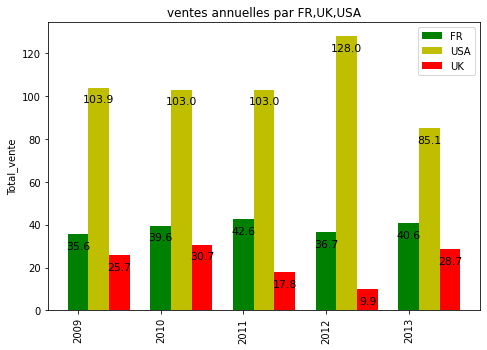

In [132]:
from matplotlib import pyplot
import numpy as np


#recupere les dataframe qui represente le total ventes par annee pour les Pays ;FR,USA,UK
Fr=vente_anne_pays.loc[vente_anne_pays.BillingCountry == "France"] 
USA = vente_anne_pays.loc[vente_anne_pays.BillingCountry == "USA"]
UK = vente_anne_pays.loc[vente_anne_pays.BillingCountry == "United Kingdom"]


X=np.arange(len(Fr))
print(X)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.bar(X+0, Fr['total_vente'],  color = 'g', width = 0.25,label="FR")
ax.bar(X+0.25,USA['total_vente'], color = 'y', width = 0.25,label="USA")
ax.bar(X+0.5,UK['total_vente'], color = 'r', width = 0.25,label="UK")

pyplot.tick_params(axis = 'x', rotation = 90)
ax.set_ylabel('Total_vente')
ax.set_title('ventes annuelles par FR,UK,USA')

#ajouter les annee sur l'axe X 
ax.set_xticks(X)
ax.set_xticklabels(Fr['annee'])

#add legend
ax.legend()

#l'ajout des label sur toutes les bar
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=11,
                   xytext = (0, -12), 
                   textcoords = 'offset points')


